## Running LAS

In [1]:
import numpy as np
from pyscf import gto, scf, lib, mcscf
import math
import time
import os
from tools import sign_control, util
from systems.hcircle import HCircle

NUM_H = 16 #total number of hydrogens
NUM_H_PER_FRAG = 2 #number of hydrogens/fragment
DIST = 1.4 #bond distance

geom = HCircle(DIST,NUM_H,NUM_H_PER_FRAG,fn="logs/hcircle.log")
las = geom.make_las_state_average()

#Build LAS states
print("Initiating LAS Model Space...")
start = time.perf_counter()
las.lasci_()
las.ci = sign_control.fix_sign(las) #sign fixing
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")
las.dump_spaces()

#Run LASSI
print("Running LASSI...")
start = time.perf_counter()
from mrh.my_pyscf import lassi
lsi = lassi.LASSI(las)
energies_lassi, civecs_lassi = lsi.kernel()
civecs_lassi = lsi.get_sivec_vacuum_shuffle(state=0) #sign fixing
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds") #Logged to hcircle.log

/home/king1305/Apps/pyscf/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
WARN: HOMO -0.0888205105374333 >= LUMO -0.0888205105374331


overwrite output file: logs/hcircle.log
Initiating LAS Model Space...
Done. Time elapsed: 23.894886854992365 seconds
Running LASSI...
Done. Time elapsed: 0.7856338129931828 seconds


## Plotting Band Structure

[-7.69 -7.26 -7.26 -7.26 -7.26 -7.26 -7.26 -7.26 -7.26 -7.32 -7.32 -7.32
 -7.32 -7.32 -7.32 -7.32 -7.32]


Text(0, 0.5, 'Energy (eV)')

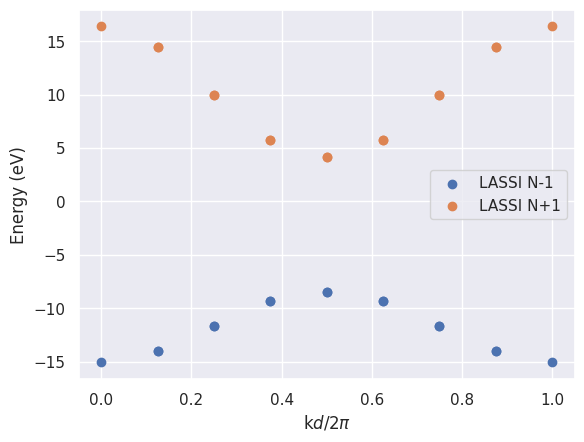

In [2]:
from tools import bandh
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

las_charges = util.las_charges(las)
hdct = bandh.make_hdct(civecs_lassi,energies_lassi,las_charges)
df = bandh.make_bands(hdct)
plt.legend()
plt.xlabel("k$d$/2$\pi$")
plt.ylabel("Energy (eV)") #Note here we plot w/ only 16 H, so less number of k points